# DL Tutorial 1: Classification and Interpretability

This notebook builds upon Michelle Lochner's [deep learning tutorial](https://github.com/MichelleLochner/ml-tutorials/blob/main/tutorial-deep-learning.ipynb)

### Open In Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Road2SKA/DL_Basics_tutorial/blob/main/classification_and_interpretability.ipynb)

# 1. Imports

Using the base Colab environment, we just need to add the GradCAM package in order to run the second part of the tutorial

In [1]:
!pip install grad-cam --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torchsummary import summary

from PIL import Image
import time
import os
import subprocess

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from google.colab import output
output.enable_custom_widget_manager()

%pylab inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Populating the interactive namespace from numpy and matplotlib
Using device: cuda


# 2. Dataset

We will use the galaxy_zoo data made of 1000 galaxy images, evenly divided into 'Elliptical' (coded as 0) and 'Spiral' (1) classes.

The data should be in the same folder as this notebook. 

Run the following cell **ONLY IF** you haven't downloaded the data yet.

If needed, uncomment the first two lines too clean up the current directory.

In [4]:
#! rm -rf galaxy_zoo 
#! rm galaxy_zoo.zip

!wget https://raw.githubusercontent.com/MichelleLochner/ml-tutorials/main/data/galaxy_zoo.zip
!unzip -q galaxy_zoo.zip -d galaxy_zoo
!ls -orth

--2026-01-31 17:21:26--  https://raw.githubusercontent.com/MichelleLochner/ml-tutorials/main/data/galaxy_zoo.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82165517 (78M) [application/zip]
Saving to: ‘galaxy_zoo.zip’

galaxy_zoo.zip      100%[===================>]  78.36M   167MB/s    in 0.5s    

2026-01-31 17:21:27 (167 MB/s) - ‘galaxy_zoo.zip’ saved [82165517/82165517]

total 79M
drwxr-xr-x 1 root 4.0K Dec  9 14:42 sample_data
-rw-r--r-- 1 root  79M Jan 31 17:21 galaxy_zoo.zip
drwxr-xr-x 3 root 4.0K Jan 31 17:21 galaxy_zoo


Now we will define the preprocessing pipeline. It includes: 
 - Randomly flipping the images to perform data augmentation
 - Turning the Numpy array into Torch tensor

In [5]:
preprocess = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ])

We will now define the dataset class. Its main purpose is to open the data, make it ready for training and preload it on the GPU.

Note that you can set `maxsize` in order to limit the number of images in the dataset.

In [6]:
class ThumbnailsDataset(Dataset):
    def __init__(self, root_dir, transform=None, device=None, maxsize=None):
        """
        Dataset that loads all images once and preloads them to GPU memory.

        Parameters
        ----------
        root_dir : str
            Root directory. Each subfolder = one class.
        transform : torchvision.transforms, optional
            Transforms to apply (must output a Tensor).
        device : torch.device or str, optional
            Device where data will be stored. Default: 'cuda' if available.
        """
        self.transform = transform
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {c: i for i, c in enumerate(classes)}

        self.images = []
        self.targets = []
        self.names = []

        print(f"🔄 Preloading dataset to {self.device}...")

        for c in classes:
            class_dir = os.path.join(root_dir, c)
            files = [f for f in os.listdir(class_dir) if f.lower().endswith(".png")]
            if maxsize is not None:
              files = files[:maxsize]

            for f in files:
                path = os.path.join(class_dir, f)
                im_name = os.path.splitext(f)[0]

                image = Image.open(path).convert("RGB")

                if self.transform:
                    image = self.transform(image)  # Must produce a tensor

                if not torch.is_tensor(image):
                    raise TypeError("Transform must convert images to torch.Tensor")

                # Move to GPU NOW
                image = image.to(self.device, non_blocking=True)

                self.images.append(image)
                self.targets.append(self.class_to_idx[c])
                self.names.append(im_name)

        self.targets = torch.tensor(self.targets, device=self.device)

        print(f"✅ Loaded {len(self.images)} images.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return {
            "image": self.images[idx],     # Already on GPU
            "name": self.names[idx],
            "class": self.targets[idx]     # Already on GPU
        }

We can now create the training and testing datasets.

In [7]:
training_dataset = ThumbnailsDataset("galaxy_zoo/galaxy_zoo/training", transform=preprocess, maxsize=None)
test_dataset = ThumbnailsDataset("galaxy_zoo/galaxy_zoo/test", transform=preprocess)

🔄 Preloading dataset to cuda...
✅ Loaded 800 images.
🔄 Preloading dataset to cuda...
✅ Loaded 200 images.


Let's create a visualization function that we will reuse through the notebook

In [8]:
def plot_galaxy(dataset, idx):
    """
    Convenience function to make a nice image of a particular galaxy
    """
    # Retrieve the image
    im = dataset[idx]['image'].cpu().detach()
    # For whatever reason, torch and matplotlib expect different orders of the channels so we need to permute them
    im = im.permute(1, 2, 0)
    # Show the image
    imshow(im)
    
    # Get the class and put it in a title
    target = dataset[idx]['class']
    if target == 0:
        img_class = 'elliptical'
    else:
        img_class = 'spiral'
    xticks([])
    yticks([])
    title(img_class)

Let's see random samples from the dataset.

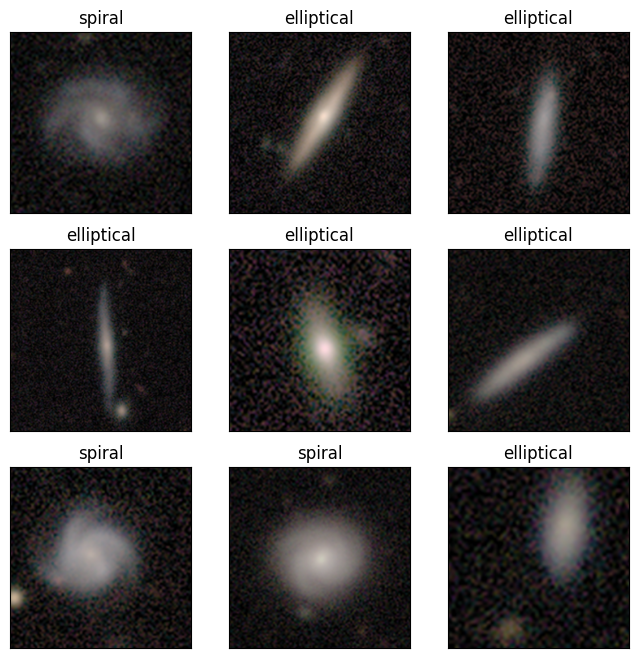

In [9]:
# Pick some random examples
inds = np.random.choice(np.arange(len(training_dataset)), 9, replace=False)

figure(figsize=(8,8))
for i in range(9):
    subplot(3,3,i+1)
    idx = inds[i]
    plot_galaxy(training_dataset, idx)

# 3. CNN Model

We can then define our little custom CNN architecture. 

In the `__init__` we define each layers:
 - We start with two 2D convolutions (`nn.Conv2d`) with 32 filters of size 3x3 to exctract low-level features. We then apply a max pooling operation to downsample data (`nn.MaxPool2d`), using 2x2 kernel size and using a stride of 2.
 - We extract higher-level features through a next pair of convolutions with 64 3x3 filters each. We again place a max pooling operations right after.
 - The output of the `max_pool2` layer is passed to a dense layer (`nn.Linear`) in order to process the extracted features. Non-linearity is added with a ReLU activation (`nn.ReLU()`). Finally the last layer reduces the information to a `num_classes`-vector to predict the predicted probability of each class.


In [10]:
# A custom CNN class
class ConvNeuralNet(nn.Module):
#  Determine what layers and their order in CNN object
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        # Dynamically calculate the input size for the first fully connected layer
        # Create a dummy input tensor
        dummy_input = torch.zeros(1, 3, 224, 224)
        # Pass it through the convolutional and pooling layers
        out = self.conv_layer1(dummy_input)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
        # Calculate the flattened size
        flattened_size = out.flatten(1).shape[1]

        self.fc1 = nn.Linear(flattened_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    # Progresses data across layers
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)

        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)

        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

We now instantiate a classifier with our ConvNeuralNet class, using `num_classes=2` as this is the case for our data.

Note that we put the model on the GPU.

You can also choose to preload a deeper archistecture, a ResNet18 from PyTorch, to test if it performs better.

The `summary` functions details the layers and number of free parameters in the model.

In [11]:
# Use a custom CNN
classifier = ConvNeuralNet(2).to(device) 

# OR use a pre-defined ResNet model
#classifier = models.resnet18(num_classes=2).to(device) 
summary(classifier, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             896
            Conv2d-2         [-1, 32, 220, 220]           9,248
         MaxPool2d-3         [-1, 32, 110, 110]               0
            Conv2d-4         [-1, 64, 108, 108]          18,496
            Conv2d-5         [-1, 64, 106, 106]          36,928
         MaxPool2d-6           [-1, 64, 53, 53]               0
            Linear-7                   [-1, 64]      11,505,728
              ReLU-8                   [-1, 64]               0
            Linear-9                    [-1, 2]             130
Total params: 11,571,426
Trainable params: 11,571,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 39.36
Params size (MB): 44.14
Estimated Total Size (MB): 84.07
----------------------------------

# 4. Training

We are getting closer to actual training !

We need here to define our loss and our optimiser.

As it's a classification task, we use the Cross Entropy (`nn.CrossEntropyLoss`) as loss function. It needs to be passed to the GPU (if available).

The optimizer will be a simple Stochastic Gradient Descent (`torch.optim.SGD`).


In [12]:
learning_rate = 3e-3
batch_size = 64

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(classifier.parameters(), lr=learning_rate)

training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_losses, test_losses, train_acc, test_acc = [], [], [], []

We define the training and testing loops !

In the training, we perform the following crucial steps:
 - Sample a random batch from the dataset.
 - Evaluate the model and compute the loss.
 - Then we compute the gradients and update the network's parameters.

In addition, we compute the accuracy to track it during the training.

The testing loop does the same but without the parameters update. We will compare the evolution of the loss and of the accuracy over training for both the test and train data.


In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """
    Function to iterate through the training set and train the network.
    """
    losses = []
    size = len(dataloader.dataset)
    correct = 0

    for batch, dat in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(dat['image'])
        loss = loss_fn(pred, dat['class'])
        correct += (pred.argmax(1) == dat['class']).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().detach().numpy()[None])

        if False: #batch % 100 == 0:
            loss, current = loss.item(), batch * len(dat['image'])
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    correct /= size
    return np.concatenate(losses), np.array([100*correct])


def test_loop(dataloader, model, loss_fn):
    """
    Function to iterate through the test data and evaluate the algorithm.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    losses = []
    with torch.no_grad():
        for dat in dataloader:
            pred = model(dat['image'])
            test_loss += loss_fn(pred, dat['class']).item()
            correct += (pred.argmax(1) == dat['class']).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test accuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} ")
    return np.array([test_loss]), np.array([100*correct])

Now let's launch a training for 50 epochs 🚀

In [14]:
# Now we actually iterate through each epoch, checking performance as we go.
t1 = time.perf_counter()
epochs = 50


for t in range(epochs):
    print(f"Epoch {t+1}")
    trainloss, trainacc = train_loop(training_dataloader, classifier, loss_fn, optimizer)
    testloss, testacc = test_loop(test_dataloader, classifier, loss_fn)
    train_losses.append(trainloss)
    test_losses.append(testloss)
    train_acc.append(trainacc)
    test_acc.append(testacc)
all_train_losses = np.concatenate(train_losses)
all_test_losses = np.concatenate(test_losses)
all_train_acc = np.concatenate(train_acc)
all_test_acc = np.concatenate(test_acc)

print("Done!")
print(f"Time taken {time.perf_counter()-t1:.2f}s")


Epoch 1
Test accuracy: 50.0%, avg loss: 0.690795 
Epoch 2
Test accuracy: 72.5%, avg loss: 0.683262 
Epoch 3
Test accuracy: 75.0%, avg loss: 0.676936 
Epoch 4
Test accuracy: 73.0%, avg loss: 0.672613 
Epoch 5
Test accuracy: 72.5%, avg loss: 0.663145 
Epoch 6
Test accuracy: 76.0%, avg loss: 0.640388 
Epoch 7
Test accuracy: 77.0%, avg loss: 0.626933 
Epoch 8
Test accuracy: 76.5%, avg loss: 0.616536 
Epoch 9
Test accuracy: 77.0%, avg loss: 0.576528 
Epoch 10
Test accuracy: 74.5%, avg loss: 0.576327 
Epoch 11
Test accuracy: 79.0%, avg loss: 0.555371 
Epoch 12
Test accuracy: 79.0%, avg loss: 0.513063 
Epoch 13
Test accuracy: 80.5%, avg loss: 0.458165 
Epoch 14
Test accuracy: 76.5%, avg loss: 0.488392 
Epoch 15
Test accuracy: 82.0%, avg loss: 0.428470 
Epoch 16
Test accuracy: 80.5%, avg loss: 0.424727 
Epoch 17
Test accuracy: 80.0%, avg loss: 0.438254 
Epoch 18
Test accuracy: 83.5%, avg loss: 0.399380 
Epoch 19
Test accuracy: 83.5%, avg loss: 0.343330 
Epoch 20
Test accuracy: 85.5%, avg loss:

Let's check the evolution of the loss and accuracy.

**Exercize**
- Note the final value for the test accuracy.
- Try to change the architecture or the hyperparameters. Can you improve it ?

650


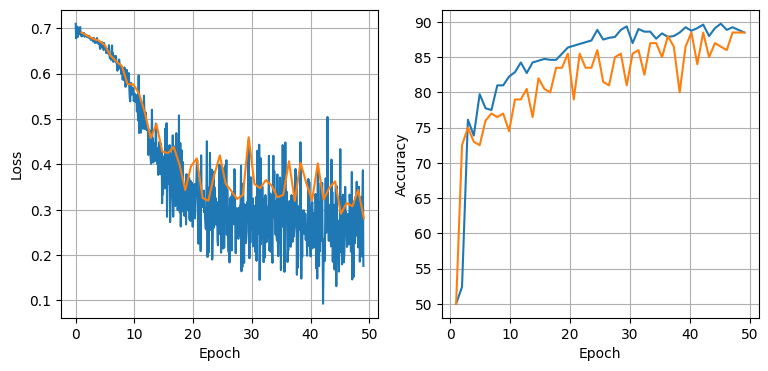

In [15]:
batches = np.linspace(0, epochs-1, all_train_losses.size)
btch_per_epoch = int(all_train_losses.size/epochs)

figure(figsize=(9,4))

subplot(1,2,1)
plot(batches, all_train_losses)
plot(batches[::btch_per_epoch]+1, all_test_losses)
xlabel('Epoch')
ylabel('Loss')
grid()
print(all_train_losses.size)
subplot(1,2,2)
plot(batches[::btch_per_epoch]+1, all_train_acc)
plot(batches[::btch_per_epoch]+1, all_test_acc)
xlabel('Epoch')
ylabel('Accuracy')
grid()

# 5. Testing the model

We start by computing the predictions for the whole test data

In [16]:
# Collect a set of predictions for the test data
predictions = []
targets = []
test_imgs = []
with torch.no_grad():
    for dat in test_dataloader:
        pred = classifier(dat['image'])
        predictions += list(pred.argmax(1).cpu().detach().numpy())
        targets += list(dat['class'].cpu().detach().numpy())
        test_imgs += list(dat['image'].cpu().detach().numpy().transpose(0,2,3,1))
targets = np.array(targets)
predictions = np.array(predictions)
test_imgs = np.array(test_imgs)

Let's look at some galaxies that were correctly classified.

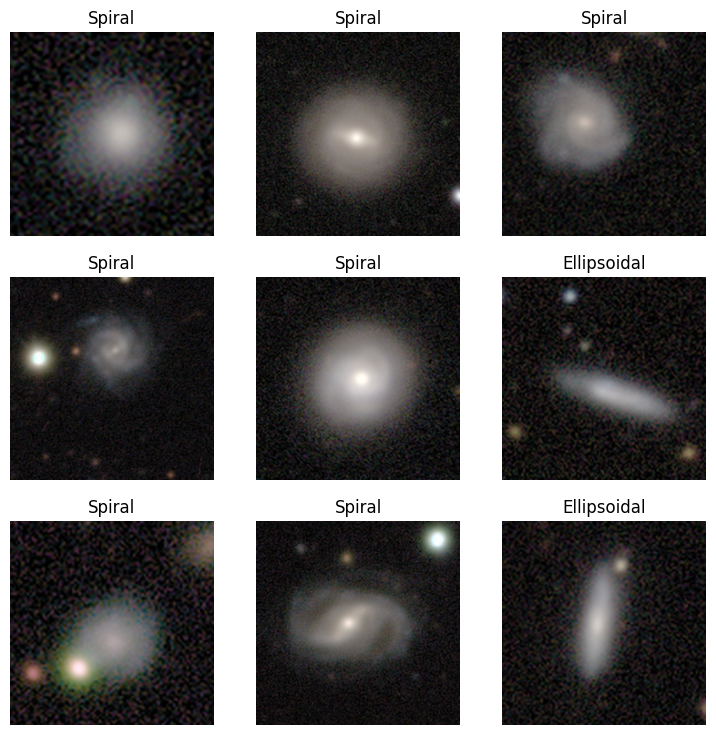

In [17]:
correct_inds = np.random.choice(np.arange(len(targets))[targets==predictions], 9, replace=False)
figure(figsize=(9,9))
for i in range(9):
    subplot(3,3,i+1)
    idx = correct_inds[i]
    imshow(test_imgs[idx])
    axis('off')
    title("Spiral" if targets[idx]==1 else "Ellipsoidal")

And now at galaxies that were incorrectly classified.

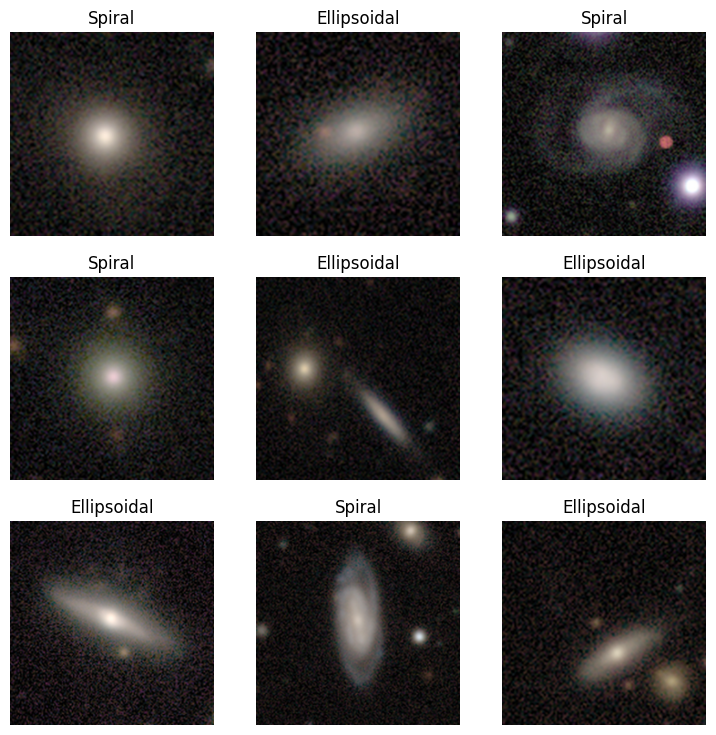

In [18]:
wrong_inds = np.random.choice(np.arange(len(targets))[targets!=predictions], 9, replace=False)
figure(figsize=(9,9))
for i in range(9):
    subplot(3,3,i+1)
    idx = wrong_inds[i]
    imshow(test_imgs[idx])
    axis('off')
    title("Spiral" if targets[idx]==1 else "Ellipsoidal")

The confusion matrix is an essential inspection tool. 

The diagonal counts the number of galaxies that were correctly classified from each class.

The off-diagonal elements inform us on the ill-classified images. Which class is better identified for the model ? 

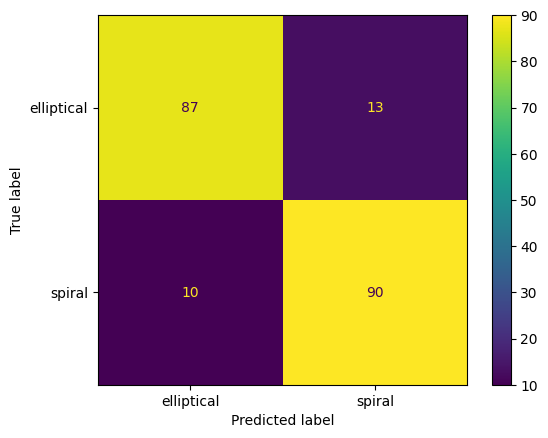

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(targets, predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=['elliptical', 'spiral'])
disp.plot()

# 6. Interpreting the model

Here we will use [GradCAM](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html) an interpretability tool. It gives us an idea of which regions of the image the network uses to make its prediction, for a specific image.

Start by initializing GradCAM. 

In [20]:
target_layers = [classifier.conv_layer4] #for resnet use classifier.layer4[-1]
cam = GradCAM(model=classifier, target_layers=target_layers)

Now let's look at where the networks focuses for well classified images.

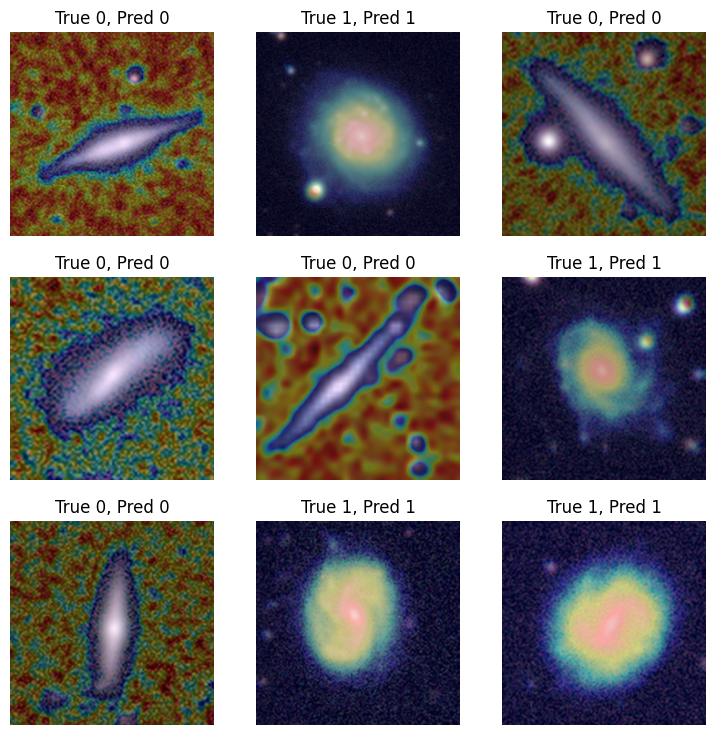

In [21]:
correct_inds = np.random.choice(np.arange(len(targets))[targets==predictions], 9, replace=False)
figure(figsize=(9,9))
for i in range(9):
    subplot(3,3,i+1)
    idx = correct_inds[i]
    #targets_cam = [ClassifierOutputTarget()]
    input_tensor = torch.from_numpy(test_imgs[idx][None].transpose(0,3,1,2))
    grayscale_cam = cam(input_tensor=input_tensor) #, targets=targets_cam)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(test_imgs[idx], grayscale_cam, use_rgb=True, image_weight=0.8)
    imshow(visualization)
    title(f"True {targets[idx]}, Pred {predictions[idx]}")
    axis('off')

And now for ill-classified images.

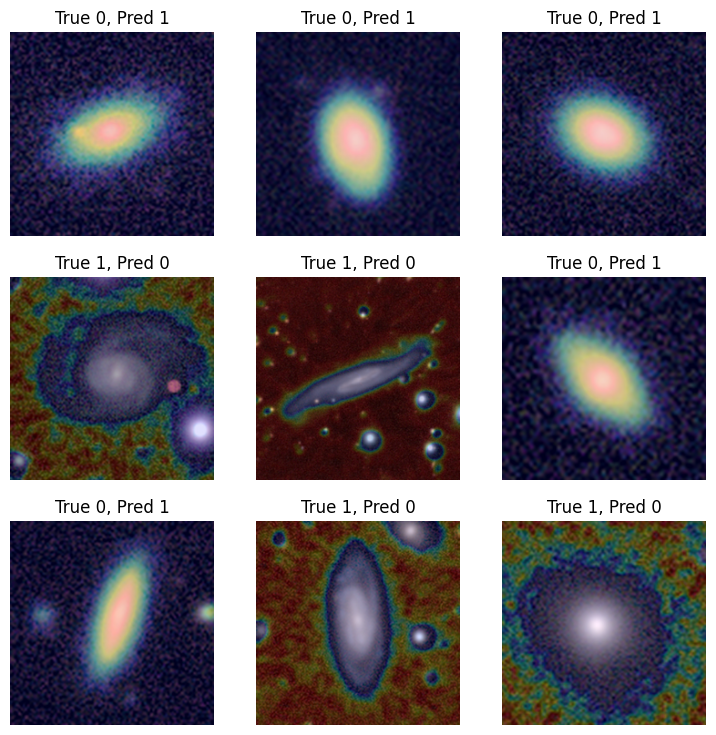

In [22]:
wrong_inds = np.random.choice(np.arange(len(targets))[targets!=predictions], 9, replace=False)
figure(figsize=(9,9))
for i in range(9):
    subplot(3,3,i+1)
    idx = wrong_inds[i]
    #targets_cam = [ClassifierOutputTarget()]
    input_tensor = torch.from_numpy(test_imgs[idx][None].transpose(0,3,1,2))
    grayscale_cam = cam(input_tensor=input_tensor) #, targets=targets_cam)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(test_imgs[idx], grayscale_cam, use_rgb=True, image_weight=0.8)
    imshow(visualization)
    title(f"True {targets[idx]}, Pred {predictions[idx]}")
    axis('off')

**Exercize**

In the GradCAM package, several other methods are available (e.g. GradCAM++). Try them and see if the output differs.


---

This is the end of this tutorial, hope you enjoyed it !

